In [1]:
## installing required packages
!pip install gym
!pip install swig
!sudo apt-get update > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install box2d-py --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
## importing required modules

import os

import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [3]:
# Mount Google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change current working directory to HW directory
os.chdir('/content/drive/My Drive/Deep Learning Google Colab/HW11')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


### Deep Q-Network (DQN) with Lunar Lander Problem

 Environment and Agent Setup

In [34]:
# Initializing the Lunar environment

env = gym.make('LunarLander-v2')
env.seed(1)
print('State shape: ', env.observation_space.shape)
print('Number of actions required: ', env.action_space.n)

State shape:  (8,)
Number of actions required:  4


#### Defining Neural Network 

In [35]:
# Since `LunarLander-v2` environment is sort of simple envs, we don't need complicated architecture. 
# We just need non-linear function approximator that maps from state to action.

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size --> Dimension of each state
            action_size --> Dimension of each action
            seed --> random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        """Build a network that maps state to action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [19]:
## Defining hyperparameters 

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount 
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # network update frequency

In [36]:
## keeping device as cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Defining Agent function 

In [37]:
class Agent():
    """Agent interacts with environment and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size --> dimension of each state
            action_size --> dimension of each action
            seed (int) --> random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like) --> current state
            eps (float)--> epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable])--> tuple of (s, a, r, s', done) tuples 
            gamma (float)--> discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)

        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Loss calculation (Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model --> weights will be copied from
            target_model -->  weights will be copied to
            tau --> interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

##### Defining Replay Buffer

In [38]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size --> dimension of each action
            buffer_size -->  maximum size of buffer
            batch_size  --> size of each training batch
            seed --> random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Training Process

In [40]:
def DQN(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes --> maximum number of training episodes
        max_t --> maximum number of steps per episode
        eps_star --> starting value of epsilon, for epsilon-greedy action selection
        eps_end --> minimum value of epsilon
        eps_decay --> multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save score to average of 100 episodes
        scores.append(score)              # save score to overall
        eps = max(eps_end, eps_decay*eps) # decreasing epsilon
        if i_episode % 50 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window)>=200.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'agent2_checkpoint.pth')
            break
        if i_episode == n_episodes:
          print(f'Max episodes reached! Agent did not solve the environment.')
          torch.save(agent.qnetwork_local.state_dict(), 'agent2_checkpoint.pth')
    return scores

In [23]:
agent = Agent(state_size=8, action_size=4, seed=0)
scores = DQN()

Episode 50	Average Score: -162.16
Episode 100	Average Score: -164.29
Episode 150	Average Score: -148.08
Episode 200	Average Score: -112.27
Episode 250	Average Score: -79.06
Episode 300	Average Score: -61.57
Episode 350	Average Score: -43.48
Episode 400	Average Score: -29.19
Episode 450	Average Score: -17.51
Episode 500	Average Score: 17.15
Episode 550	Average Score: 80.77
Episode 600	Average Score: 147.16
Episode 650	Average Score: 190.47

Environment solved in 565 episodes!	Average Score: 201.17


### Plotting the learning progress

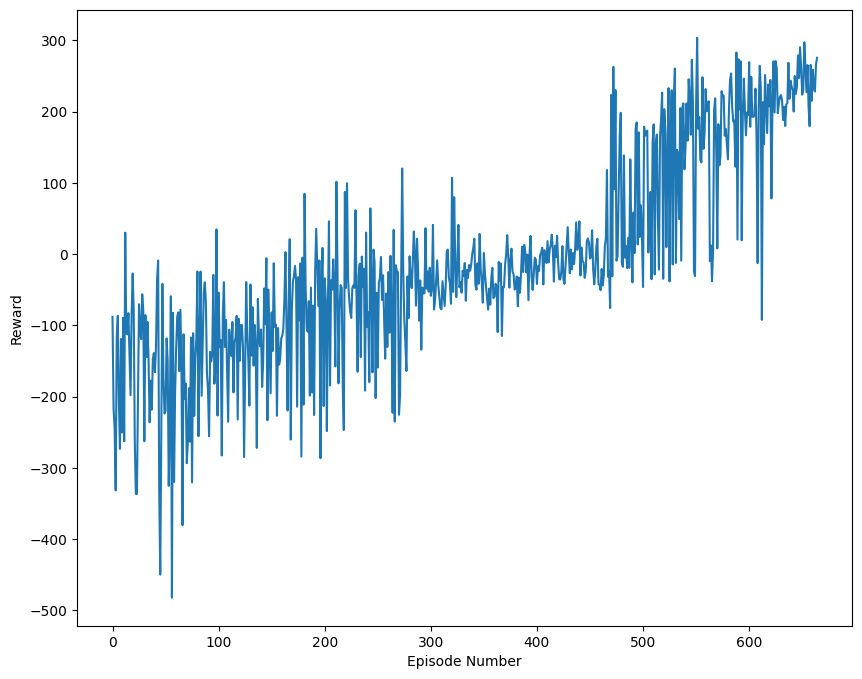

In [24]:
# plot the scores
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Reward')
plt.xlabel('Episode Number')
plt.show()

#### Showing one episode

In [18]:
## function for saving agent in environment as video

def save_video_of_model(agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path=f'./{env_name}_2.mp4')
    agent.qnetwork_local.load_state_dict(torch.load('./agent2_checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        
        action = agent.act(state)

        state, reward, done, _ = env.step(action)        
    env.close()

## function to show video
def show_video(file_path):
  video = io.open(file_path, 'r+b').read()
  encoded = base64.b64encode(video)
  display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))


In [31]:
agent = Agent(state_size=8, action_size=4, seed=1)
save_video_of_model(agent, 'LunarLander')

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:601: UserWarning: WARN: Using the latest versioned environment `LunarLander-v2` instead of the unversioned environment `LunarLander`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `rende

In [32]:
show_video('./LunarLander.mp4')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Training another Agent but with changed hyperparamters

In [33]:
## Defining new hyperparameters 

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 32         # minibatch size  - chnaged this 
GAMMA = 0.99            # discount 
TAU = 1e-3              # for soft update of target parameters
LR = 0.0001              # learning rate  - changed this
UPDATE_EVERY = 4        # network update frequency

##### Training Agent

In [41]:
agent = Agent(state_size=8, action_size=4, seed=1)
scores = DQN()

Episode 50	Average Score: -208.04
Episode 100	Average Score: -222.58
Episode 150	Average Score: -218.18
Episode 200	Average Score: -205.14
Episode 250	Average Score: -223.95
Episode 300	Average Score: -230.88
Episode 350	Average Score: -162.64
Episode 400	Average Score: -96.89
Episode 450	Average Score: -90.28
Episode 500	Average Score: -84.14
Episode 550	Average Score: -74.90
Episode 600	Average Score: -62.24
Episode 650	Average Score: -55.14
Episode 700	Average Score: -60.11
Episode 750	Average Score: -66.22
Episode 800	Average Score: -64.05
Episode 850	Average Score: -68.32
Episode 900	Average Score: -71.96
Episode 950	Average Score: -59.86
Episode 1000	Average Score: -51.58
Max episodes reached! Agent did not solve the environment.


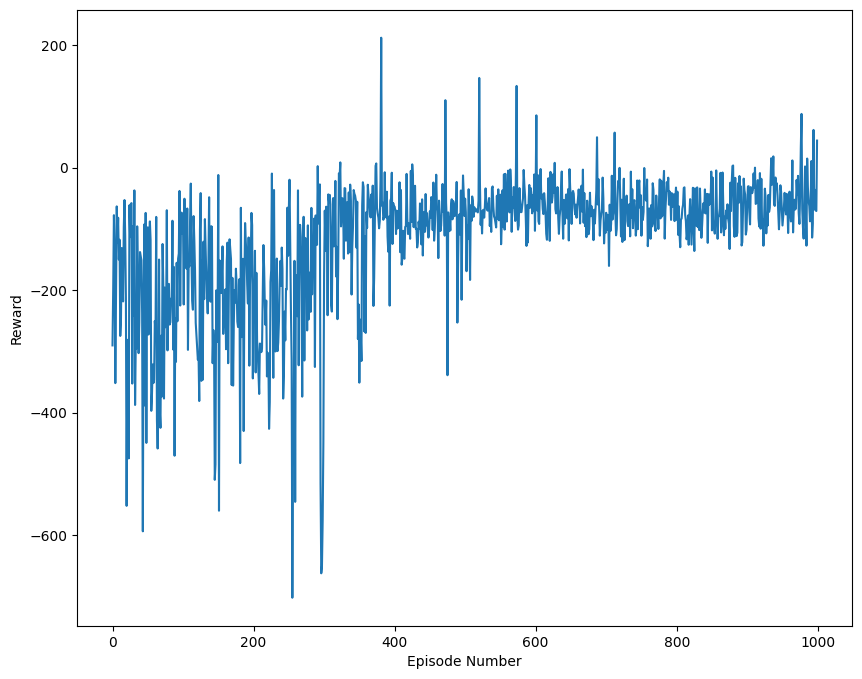

In [42]:
# plot the scores
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Reward')
plt.xlabel('Episode Number')
plt.show()

In [43]:
agent = Agent(state_size=8, action_size=4, seed=1)
save_video_of_model(agent, 'LunarLander')

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [44]:
show_video('./LunarLander_2.mp4')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## About Parameters 

The hyperparamaters used for training are given below with details:

BUFFER_SIZE - This determines the Replay buffer size. The Replay Buffer is where the Agent's past experiences are stored and later this is used to train the network.

BATCH_SIZE - This defines the number of experince data collected from the Replay bufferat each training epoch. 

GAMMA - This is the discount factor used to discount the future rewards. It determines how much importance should be future rewards in comparison to immediate rewards.

TAU - This is a factor to update the target network weights in a Deep Reinforcement learaning network. 

LR - Learning rate determines the step-size factor of the gradient descent towards reaching the minima so that the algorith converges. This factor helps determine the weight updates. 

UPDATE_EVERY - It determines is the number of actions taken by the Agent before updating the network weights. 




There are two Agents trained in this notebook. The difference between the two are the initiating hyper paramters. 

------------------
In the first one, the hyper parameters are:

BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64         
GAMMA = 0.99             
TAU = 1e-3              
LR = 5e-4                
UPDATE_EVERY = 4   

The Agent solved the environment in 565 episodes and reached the set average reward limit. 

----------------
Whereas the second set of hyperparaneters are (only batch_size and learning rate was changed):

BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 32         
GAMMA = 0.99           
TAU = 1e-3              
LR = 0.0001              
UPDATE_EVERY = 4  

The batch size and learning rate were reduced and then agent was trained. The Agent did not solve the environment and the limit of 1000 episodes was reached by then. 

This shows that learning rate plays an important role in the model converging, as the learning rate was decreased, the agent did not converge as the previous instance. 

## Agent Performance

In the first instance, the Agent solved the environment within 565 episodes. The Agent is performing well and displaying the landing within the checkposts. The average reward is seen to be steadily increasing with a small increase seen from episode 50 to 100 but later increasing in almost equal amounts every 50 episodes until the required reward average was reached. 

-------------
In the second instance, the Agent did not solve the environment. It can be seen that the average score was not decreasing after a point. this could be due to the decrease in learning rate value. The video of the lunar lander in this instance does not land in the checkpoint area as it is not trained.  